## Extracted Action model: Connectivity

A key critiera for analysing a planning domain is the nature of its connectivity. This section examines the connectivity between the preconditions and effects within the collection of extracted action models.

In [41]:
import json

output_dir = '../examples'
data_dir = '../src/data'
INPUT_FILE_PATH = f'{output_dir}/extracted_filtered_STRIPS.json'
SEMANTIC_TREE_PATH = f'{data_dir}/vn_semanticrole_hierarchy.json'

with open(INPUT_FILE_PATH, 'r', encoding='utf-8') as f:
    am_data = json.load(f)

with open(SEMANTIC_TREE_PATH, 'r', encoding='utf-8') as f:
    tree_data = json.load(f)

To generalise the parameters for each predicate in the precondition and effects between models, the ThemRole hierarchy is utilised. Specifically, the common ancestor between two ThemRole is compared. If a non-root common ancestor exists, the roles are considered similar. Predicates with arguments that have similar themroles are, in turn, considered connected.

The following section counts the incoming link and outgoing links for each model. An incoming link is defined as an effect from another model connecting to the precondition of the current model. Conversely, an outgoing link is a effect from the current model connecting to the precondition of another model. For the purposes of this analysis, two models are considered interconnected if at least one of their respective predicates is connected.

In [42]:
from vn2am.semantic_tree import build_semantic_graph, build_value_node_map
from vn2am.utils import link_post_to_pre, link_pre_to_post

root = build_semantic_graph(tree_data)
value_to_node = build_value_node_map(root)

links = {}
for entry in am_data:
    verb = entry.get('class_id', 'null')
    frames = entry.get('frames', -1)
    frame_links = []
    for i, frame in enumerate(frames):
        preconds = frame.get('preconditions', -1)
        postconds = frame.get('postconditions', -1)
        incoming_links = link_pre_to_post(preconds, am_data, value_to_node)
        outgoing_links = link_post_to_pre(postconds, am_data, value_to_node)
        new_frame = {
            "incoming_links": incoming_links,
            "preconditions_count": len(preconds),
            "incoming_links_count": sum(1 for v in incoming_links.values() if v),
            "outgoing_links": outgoing_links,
            "postconditions_count": len(postconds),
            "outgoing_links_count": sum(1 for v in outgoing_links.values() if v),
        }
        frame_links.append(new_frame)
    links[verb] = {
        "action_model": frame_links,
    }

Based on the data collected from a total of 432 action models, the analysis of connectivity reveals the following: 187 models possess at least one incoming link and 238 models have at least one outgoing link.

Further statistics details are summaried below:
- incoming links less than its preconditions: 200
- outgoing links less than its postconditions: 271
- model without incoming links: 245
- model without outgoing links: 194
- model with both links: 166
- model with no links: 173
- perfectly incoming linked (#incoming links = #preconditions): 138
- perfectly outgoing linked (#outgoing links = #postconditions): 161

In [ ]:
incoming_less_than_precond = 0
outgoing_less_than_postcond = 0
no_incoming = 0
no_outgoing = 0
both_empty = 0
both_linked = 0
perfectly_in_linked = 0
perfectly_out_linked = 0
unified_precond = 0
unified_effect = 0


for verb, entry in links.items():
    for frame in entry['action_model']:
        incoming_count = frame['incoming_links_count']
        outgoing_count = frame['outgoing_links_count']
        precond_count = frame['preconditions_count']
        postcond_count = frame['postconditions_count']
        
        if incoming_count > 0:
            unified_precond += 1
        if outgoing_count > 0:
            unified_effect += 1
        
        if incoming_count < precond_count:
            incoming_less_than_precond += 1
        if outgoing_count < postcond_count:
            outgoing_less_than_postcond += 1
        if incoming_count == 0:
            no_incoming += 1
        if outgoing_count == 0:
            no_outgoing += 1
        if incoming_count > 0 and outgoing_count > 0:
            both_linked += 1
        if incoming_count == 0 and outgoing_count == 0:
            both_empty += 1
        if incoming_count == precond_count and incoming_count > 0:
            perfectly_in_linked += 1
        if outgoing_count == postcond_count and outgoing_count > 0:
            perfectly_out_linked += 1

print(f"totoal action models: {sum(len(entry['action_model']) for entry in links.values())}")
print(f"have at least one incoming link: {unified_precond}")
print(f"have at least one outgoing link: {unified_effect}")
print(f"incoming links less than preconditions: {incoming_less_than_precond}")
print(f"outgoing links less than postconditions: {outgoing_less_than_postcond}")
print(f"model without incoming links: {no_incoming}")
print(f"model without outgoing links: {no_outgoing}")
print(f"model with both links: {both_linked}")
print(f"model with no links: {both_empty}")
print(f"perfectly incoming linked: {perfectly_in_linked}")
print(f"perfectly outgoing linked: {perfectly_out_linked}")

totoal action models: 432
have at least one incoming link: 187
have at least one outgoing link: 238
incoming links less than preconditions: 200
outgoing links less than postconditions: 271
model without incoming links: 245
model without outgoing links: 194
model with both links: 166
model with no links: 173
perfectly incoming linked: 138
perfectly outgoing linked: 161


The graph demonstrates the percentage of incoming links relative to preconditions and outgoing links relative to effects. A primary observation from the graph is that both incoming link and outgoing link tend to be either fully matched or not matched at all. For models with multiple conditions that are partially matched, the matching percentage varies, ranging from 20% to 80%. In these instances of partial matching, the most frequent scenario for both incoming and outgoing links is a 50% match. The underlying reason for this observed distribution requires further analysis to determine whether it is an inherent property of the verbs or a result of the annotation process.

The graph demonstrate the percentage between incoming links against precondition and outgoing links against effects. It shows that both incoming link and outgoing link are either completely matched or do not match any. This probably due to the length of conditions are generally short and abstract. 

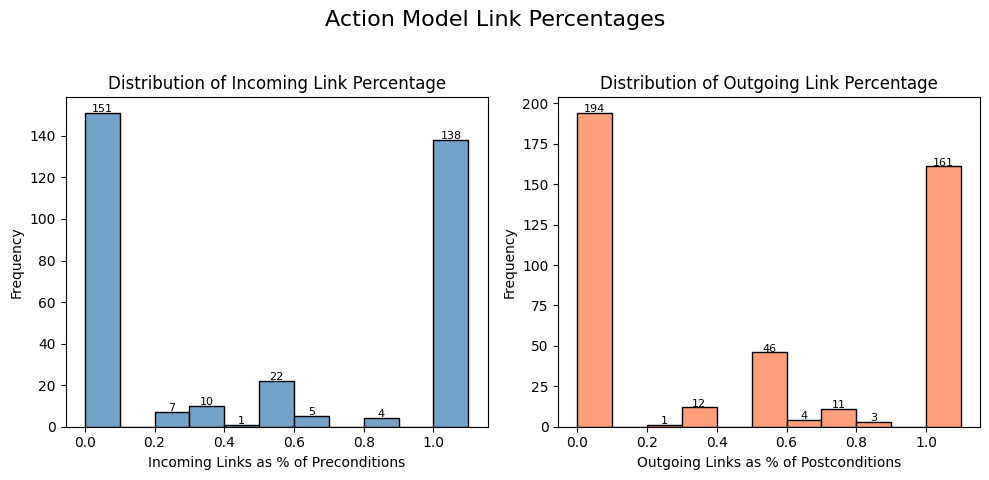

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

in_percentages = []
out_percentages = []

for entry in links.values():
    action_models = entry.get('action_model', {})
    for model in action_models:
        pre_count = model.get('preconditions_count', 0)
        in_count = model.get('incoming_links_count', 0)
        out_count = model.get('outgoing_links_count', 0)
        post_count = model.get('postconditions_count', 0)
        if pre_count > 0:
            percentage = in_count / pre_count
            in_percentages.append(percentage)
        if post_count > 0:
            percentage = out_count / post_count
            out_percentages.append(percentage)

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1]

# plot: distribution of incoming link percentage
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(in_percentages, bins=bins, color='steelblue')
plt.xlabel('Incoming Links as % of Preconditions')
plt.ylabel('Frequency')
plt.title('Distribution of Incoming Link Percentage')

# Add frequency labels on top of each bar
for patch in plt.gca().patches:
    height = patch.get_height()
    if height > 0:  # Only label bars with non-zero height
        plt.gca().text(patch.get_x() + patch.get_width() / 2., height + 0.5, int(height), ha="center", fontsize=8)

# plot: distribution of outgoing link percentage
plt.subplot(1, 2, 2)
sns.histplot(out_percentages, bins=bins, color='coral')
plt.xlabel('Outgoing Links as % of Postconditions')
plt.ylabel('Frequency')
plt.title('Distribution of Outgoing Link Percentage')

for patch in plt.gca().patches:
    height = patch.get_height()
    if height > 0:
        plt.gca().text(patch.get_x() + patch.get_width() / 2., height + 0.5, int(height), ha="center", fontsize=8)

plt.suptitle('Action Model Link Percentages', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()